# 1st_week_sales_pred_v002

In [20]:
import os
import sys
import gc
import itertools
import pickle
import pathlib
import datetime
from dateutil.relativedelta import relativedelta
from dotenv import load_dotenv
load_dotenv()
sys.path.append(os.getenv('UTILS_PATH'))

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import line_notify

In [21]:
import builtins
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )

In [22]:
SEED = 42
FOLD_N = 5

ディレクトリ設定

In [23]:
INPUT_DIR = os.getenv('INPUT_DIR')
OUTPUT_DIR = os.getenv('OUTPUT_DIR')
#exp_name = os.path.dirname(__file__).split('/')[-1]
exp_name = '# 1st_week_sales_pred_v002'
os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

データ読み込み

In [24]:
articles = pd.read_csv(INPUT_DIR + 'articles.csv', dtype='object')
#customers = pd.read_csv(INPUT_DIR + 'customers.csv')
transactions = pd.read_csv(INPUT_DIR + 'transactions_train.csv', dtype={'article_id':'str'}, parse_dates=['t_dat'])
#sample = pd.read_csv(INPUT_DIR + 'sample_submission.csv')

In [25]:
# label_encoding
le_cols = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']
for c in le_cols:
    le = LabelEncoder()
    articles[c] = le.fit_transform(articles[c].fillna(''))

In [26]:
transactions['1st_tran_dat'] = transactions.groupby('article_id')['t_dat'].transform('min')
transactions['1st_tran_dat_diff'] = (transactions['t_dat'] - transactions['1st_tran_dat']).dt.days
transactions2 = transactions[(transactions['1st_tran_dat'] > '2019-09-20') & (transactions['1st_tran_dat_diff'] <= 7)].copy()
transactions2 = transactions.reset_index(drop=True)

In [27]:
train = transactions2.groupby('article_id').agg({'t_dat':'count', '1st_tran_dat':'min'}).reset_index()
train.columns = ['article_id', '1st_week_sales', '1st_week_sales_dat']
train = train.merge(articles, on='article_id', how='left')

In [28]:
test = articles[~articles['article_id'].isin(transactions['article_id'].unique().tolist())].copy()
test['1st_week_sales_dat'] = datetime.datetime(2020,9,23)

# modeling

In [29]:
params = {
    "objective": "mae",
    "boosting" : "gbdt",
    "learning_rate": 0.1,
    "metric": "mae",
    "seed": SEED
}

In [30]:
target = '1st_week_sales'
features = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']

In [31]:
fi = pd.DataFrame()
oof = train[['article_id', '1st_week_sales_dat', '1st_week_sales']].copy()
oof['1st_week_sales_pred'] = np.nan
preds = np.zeros(len(test))
cv_scores = []

kf = KFold(n_splits=FOLD_N, random_state=SEED, shuffle=True)
for n, (tr_idx, vl_idx) in enumerate(kf.split(train)):

    print(f'fold{n} ' + '--'*10)
    tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
    vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=20000, early_stopping_rounds=100,verbose_eval=1000)

    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.feature_name()
    fi_tmp['importance'] = model.feature_importance(importance_type='gain')
    fi_tmp['fold'] = n
    fi = fi.append(fi_tmp)

    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    oof.loc[vl_idx, '1st_week_sales_pred'] = vl_pred

    pred = model.predict(test[features], num_iteration=model.best_iteration)
    preds += pred / FOLD_N

    cv_score = mean_squared_error(vl_y, vl_pred, squared=False)
    cv_scores.append(cv_score)
    print(f'fold{n} RMSE: ' + '{:.5f}'.format(cv_score))

test['1st_week_sales_pred'] = pred
print(f'CV SCORE: ' + '{:.5f}'.format(np.mean(cv_scores)))

fold0 --------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 83637, number of used features: 11
[LightGBM] [Info] Start training from score 64.000000


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[764]	training's l1: 227.034	valid_1's l1: 234.79
fold0 RMSE: 694.56510
fold1 --------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 83637, number of used features: 11
[LightGBM] [Info] Start training from score 65.000000
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[429]	training's l1: 229.254	valid_1's l1: 227.541
fold1 RMSE: 676.30138
fold2 --------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 83638, number of used features: 11
[LightGBM] [Info] Start training from score 65.000000
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[315]	training's l1: 230.079	valid_1's l1: 232.706
fold2 RMSE: 717.18112
fold3 --------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 83638, number of used features: 11
[LightGBM] [Info] Start training from score 65.000000
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[862]	training's l1: 224.119	valid_1's l1: 242.253
fold3 RMSE: 876.40598
fold4 --------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 83638, number of used features: 11
[LightGBM] [Info] Start training from score 65.000000
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[725]	training's l1: 227.517	valid_1's l1: 231.87
fold4 RMSE: 697.23376
CV SCORE: 732.33747


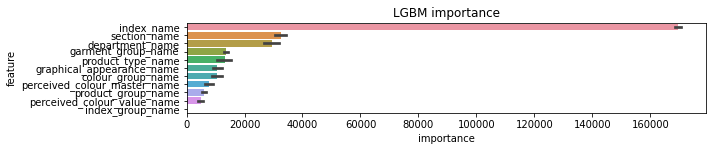

In [32]:
fi_n = fi['feature'].nunique()
order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, fi_n*0.2))
sns.barplot(x="importance", y="feature", data=fi, order=order)
plt.title(f"LGBM importance")
plt.tight_layout()
plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

結果

In [33]:
print('RMSE : ', '{:.5f}'.format(mean_squared_error(oof['1st_week_sales'], oof['1st_week_sales_pred'], squared=False)))
print('MAE  : ', '{:.5f}'.format(mean_absolute_error(oof['1st_week_sales'], oof['1st_week_sales_pred'])))
print('相関係数  : ', '{:.5f}'.format(oof[['1st_week_sales', '1st_week_sales_pred']].corr().iat[0,1]))
print('順位相関  : ', '{:.5f}'.format(oof[['1st_week_sales', '1st_week_sales_pred']].corr(method='spearman').iat[0,1]))

RMSE :  735.98485
MAE  :  233.83190
相関係数  :  0.43586
順位相関  :  0.63828


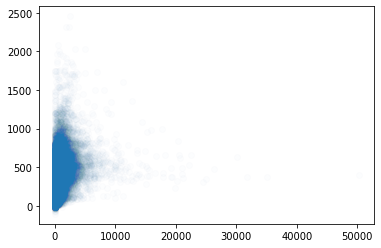

In [34]:
plt.scatter(oof['1st_week_sales'], oof['1st_week_sales_pred'], alpha=0.01)

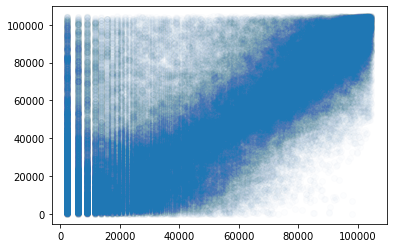

In [35]:
plt.scatter(oof['1st_week_sales'].rank(), oof['1st_week_sales_pred'].rank(), alpha=0.01)

In [36]:
usecols = ['article_id', '1st_week_sales_dat', '1st_week_sales_pred']
result = pd.concat([oof[usecols], test[usecols]])
result.to_csv(OUTPUT_DIR + f'{exp_name}/result.csv', index=False)
result

,article_id,1st_week_sales_dat,1st_week_sales_pred
0,0108775015,2018-09-20,595.365866
1,0108775044,2018-09-20,534.238842
2,0108775051,2018-09-20,503.613796
3,0110065001,2018-09-20,526.333537
4,0110065002,2018-09-20,475.416068
...,...,...,...
105529,0949323002,2020-09-23,260.161897
105533,0950449002,2020-09-23,11.580717
105535,0952937003,2020-09-23,382.970294
105540,0957375001,2020-09-23,97.731000
